# Домашнее задание 3 - NLP

Для решения ДЗ вам очень помогут семинары 5 и 6 занятий

Напоминаю, как сдаем дз
1. Копируем этот ноутбук (Файл -> Сохранить копию на Диске)
2. **Пишем свой ТГ**, чтобы легче было потом связаться. О результатах проверки сообщим в личные сообщения в телеграме!
3. Листаем, заполняем пропущенные ячейки, выполняем задания
4. Когда закончите - в левом верхнем углу нажимаете Поделиться, в общем доступе обязательно указываем "Все, у кого есть ссылка", далее нажимаем Копировать ссылку и прикладываем ссылку на степик в ответ к дз
5. Ждем фидбек в тг)

#### Дедлайн сдачи ДЗ
**19 ноября 23:59** очень прошу не опаздывать! Фидбек начнем рассылать после дедлайна дз, постараемся все проверить до дедлайна следующего ДЗ

#### Задачи
1. TF-IDF + baseline <br>
2. Attention + Positional encodings <br>
3. Seq2Seq <br>

Всего можно получить 10 баллов + доп. баллы по настроению проверяющего)) <br>
По всем вопросам: @daniil_d_d <br>
**Удачи!**

In [1]:
# Общие настройки
import os, math, random, re, json, time
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,3)

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer as SkTFIDF


RNG_SEED = 42
def set_seed(seed=RNG_SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed()

# --- viz helpers ---
def plot_curve(values, title, ylabel="score", xlabel="step"):
    xs = np.arange(1, len(values)+1)
    plt.plot(xs, values, marker="o")
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel); plt.grid(True)
    plt.show()

def plot_confusion(cm, labels):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Pred')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout(); plt.show()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

## Задача 1. Собственный TF-IDF + baseline-классификатор

Реализуйте класс MyTfidfVectorizer (аналог sklearn.TfidfVectorizer) и обучите линейный классификатор новостей.

**Данные:** ag_news (HuggingFace)

**Критерии:**
- Корректность реализации: формы, нормировка, idf/tf режимы.
- Сравнение косинусной близости с sklearn (допуск 1e-6).
- Качество: accuracy ≥ 0.87 на валидации.
- Визуализация: график зависимости метрики от гиперпараметров (min_df/max_df), вывод топ-n фичей.

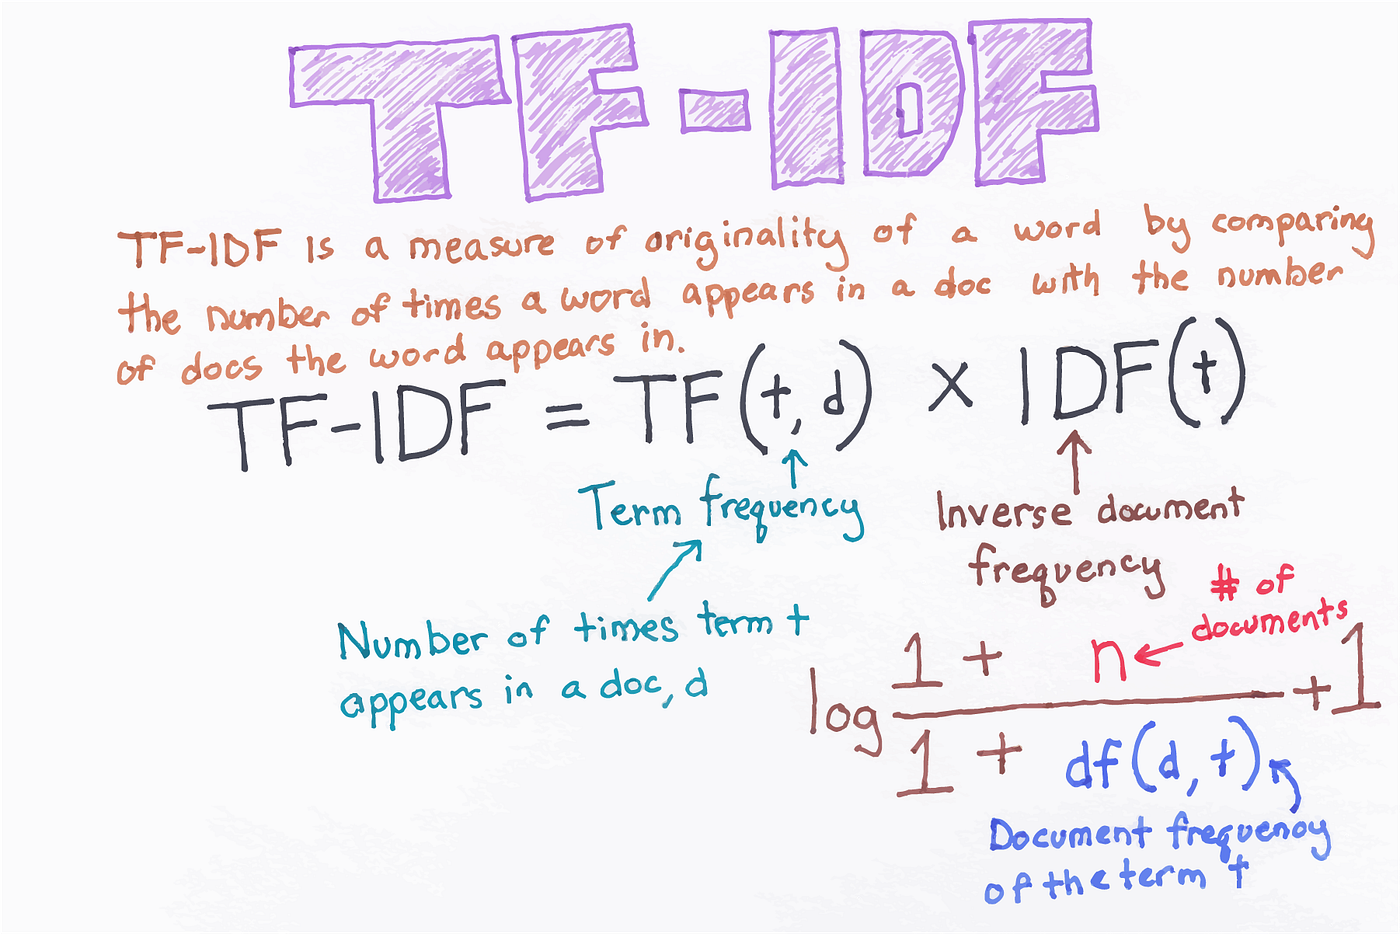

In [2]:
# --- data loader ---
def load_ag_news_or_stub(n_train=8000, n_test=2000):
        from datasets import load_dataset
        ds = load_dataset("ag_news")
        train = ds["train"].select(range(min(n_train, len(ds["train"]))))
        test  = ds["test"].select(range(min(n_test , len(ds["test"]))))
        return (list(train["text"]), list(train["label"])), (list(test["text"]), list(test["label"]))

(train_x, train_y), (test_x, test_y) = load_ag_news_or_stub()
len(train_x), len(test_x)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

(8000, 2000)

In [3]:
class MyTfidfVectorizer:
    def __init__(self, min_df=1, max_df=1.0, max_features=None,
                 ngram_range=(1,1), use_idf=True, smooth_idf=True,
                 sublinear_tf=False, norm='l2', lowercase=True):
        self.min_df = min_df
        self.max_df = max_df
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.use_idf = use_idf
        self.smooth_idf = smooth_idf
        self.sublinear_tf = sublinear_tf
        self.norm = norm
        self.lowercase = lowercase
        self.vocab_ = {}
        self.idf_ = None
        self._fitted = False

    def _tokenize(self, text):
        # YOUR CODE HERE: простой токенайзер, например латиница/цифры + lower
        # верните список токенов
        if self.lowercase:
            text = text.lower()

        tokens = re.findall(r'\b\w+\b', text)
        return tokens

    def _generate_ngrams(self, tokens):
        # YOUR CODE HERE: собрать n-граммы для диапазона ngram_range (включительно)
        ngrams = []
        min_n, max_n = self.ngram_range

        for n in range(min_n, max_n + 1):
            for i in range(len(tokens) - n + 1):
                ngram = ' '.join(tokens[i:i+n])
                ngrams.append(ngram)

        return ngrams

    def fit(self, corpus):
        # YOUR CODE HERE:
        # 1) посчитать df по документам
        # 2) отфильтровать по min_df / max_df (float -> порог по числу документов)
        # 3) отсортировать и обрезать до max_features
        # 4) посчитать idf

        # подсчитываем df по документам
        df_counter = Counter()
        for doc in corpus:
            tokens = self._tokenize(doc)
            ngrams = self._generate_ngrams(tokens)
            unique_ngrams = set(ngrams)
            df_counter.update(unique_ngrams)

        # фильтруем по min_df и max_df
        n_docs = len(corpus)
        min_df_val = self.min_df if isinstance(self.min_df, int) else self.min_df * n_docs
        max_df_val = self.max_df if isinstance(self.max_df, int) else self.max_df * n_docs

        filtered_terms = {
            term for term, count in df_counter.items()
            if min_df_val <= count <= max_df_val
        }

        # сортируем и обрезаем
        sorted_terms = sorted(filtered_terms)

        if self.max_features is not None and len(sorted_terms) > self.max_features:
            sorted_terms = sorted_terms[:self.max_features]

        self.vocab_ = {term: idx for idx, term in enumerate(sorted_terms)}

        # подсчитывваем idf
        if self.use_idf:
            self.idf_ = np.zeros(len(self.vocab_))
            for term, idx in self.vocab_.items():
                df = df_counter[term]
                if self.smooth_idf:
                    idf_val = math.log((1 + n_docs) / (1 + df)) + 1
                else:
                    idf_val = math.log(n_docs / df) + 1

                self.idf_[idx] = idf_val

        self._fitted = True
        return self

    def transform(self, corpus):
        # YOUR CODE HERE:
        # 1) собрать TF для каждого документа в текущем словаре self.vocab_
        # 2) умножить на idf
        # 3) нормировать строки по L1 или L2 (по self.norm)
        if not self._fitted:
            raise ValueError("Vectorizer not fitted yet.")

        n_docs = len(corpus)
        n_features = len(self.vocab_)
        X = np.zeros((n_docs, n_features))

        for doc_idx, doc in enumerate(corpus):
            tokens = self._tokenize(doc)
            ngrams = self._generate_ngrams(tokens)
            term_freq = Counter(ngrams)

            for term, freq in term_freq.items():
                if term in self.vocab_:
                    term_idx = self.vocab_[term]

                    if self.sublinear_tf:
                        tf = 1 + math.log(freq) if freq > 0 else 0
                    else:
                        tf = freq

                    X[doc_idx, term_idx] = tf

        if self.use_idf:
            X *= self.idf_

        # нормировка
        if self.norm == 'l2':
            norms = np.linalg.norm(X, axis=1, keepdims=True)
        elif self.norm == 'l1':
            norms = np.sum(np.abs(X), axis=1, keepdims=True)

        norms[norms == 0] = 1
        X /= norms

        return X

    def fit_transform(self, corpus):
        self.fit(corpus)
        return self.transform(corpus)

    def get_feature_names_out(self):
        # YOUR CODE HERE: вернуть список фич в порядке их индексов
        return [term for term, _ in sorted(self.vocab_.items(), key=lambda x: x[1])]


[TF-IDF + LR] accuracy = 0.8770


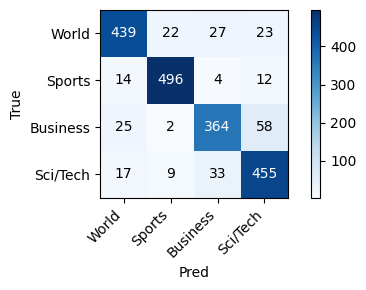

In [4]:
# --- Обучение + метрика ---
vec = MyTfidfVectorizer(min_df=3, max_df=0.9, max_features=50000,
                        ngram_range=(1,2), use_idf=True, smooth_idf=True,
                        sublinear_tf=True, norm='l2')

Xtr = vec.fit_transform(train_x)
Xte = vec.transform(test_x)

clf = LogisticRegression(max_iter=1000)
clf.fit(Xtr, train_y)
pred = clf.predict(Xte)
acc = accuracy_score(test_y, pred)
print(f"[TF-IDF + LR] accuracy = {acc:.4f}")

# Confusion matrix
label_names = ["World","Sports","Business","Sci/Tech"]
cm = confusion_matrix(test_y, pred, labels=[0,1,2,3])
plot_confusion(cm, labels=label_names)

Поздравляю! У вас получилось обучить свой собственный классификатор.

Следующая ячейка нужна для того, чтобы прогнать тесты и убедиться, что получилось добиться нужного качества)) Если не получилось - не расстраивайтесь, попробуйте посмотреть подсказки и поэкспериментировать с обучением 📚

In [5]:
# --- Проверка со sklearn ---
subset = train_x[:100]
vec_small = MyTfidfVectorizer(min_df=3, max_df=0.9, max_features=50000,
                              ngram_range=(1,2), use_idf=True, smooth_idf=True,
                              sublinear_tf=True, norm='l2')

sk = SkTFIDF(min_df=3, max_df=0.9, max_features=50000,
             ngram_range=(1,2), use_idf=True, smooth_idf=True,
             sublinear_tf=True, norm='l2')

skX = sk.fit_transform(subset).toarray()
myX = vec_small.fit_transform(subset)

i = 0
cos_my = (myX[i] @ myX[i]) / (norm(myX[i]) * norm(myX[i]) + 1e-12)
cos_sk = (skX[i] @ skX[i]) / (norm(skX[i]) * norm(skX[i]) + 1e-12)
assert abs(cos_my - cos_sk) < 1e-6, "TF-IDF не совпал со sklearn по косинусу"
print("sklearn cosine check: PASS")


sklearn cosine check: PASS


**Подсказки**.

`idf = log((1+N)/(1+df)) + 1` при `smooth_idf=True`.

Для нормировки: `X / ||X||`.

Для n-грамм используйте `' '.join(tokens[i:i+n])`.

## Задача 2. Attention своими руками + позиционные эмбеддинги

Реализовать Scaled Dot-Product Attention c causal-маской, Multi-Head Attention и позиционку (sine и RoPE). Собрать мини decoder-only char-LM, обучить на игрушечном корпусе и сравнить лосс/перплексию и длинные генерации для "sine" vs "rope".

**Данные:** Мини-корпус (tiny Shakespeare/цитаты — встроено).

**Что сделать:**
- SDPA с масками.
- MHA поверх SDPA.
- Позиционки: добавить "sine" и "rope" режимы.
- Обучение char-LM, график train/val loss, 1–2 сэмпла генерации.
- Визуализация attention-карт на коротком примере.

**Критерии:** Корректность форм/масок; наличие графиков; сравнение "sine" vs "rope"; пример генерации.

**Бонус:** добавить GQA-режим (группировка Q-голов к общим K/V) и сравнить время/лосс.

Напоминание архитектуры (decoder-block)

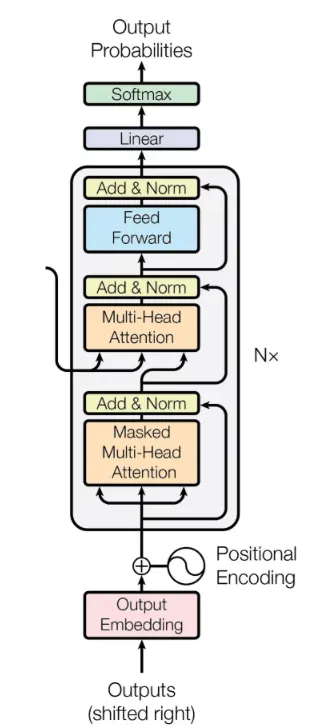

In [6]:
# ======= DATA: simple char dataset =======
def tiny_char_data():
    text = (
        "To be, or not to be, that is the question:\n"
        "Whether 'tis nobler in the mind to suffer\n"
        "The slings and arrows of outrageous fortune,\n"
        "Or to take arms against a sea of troubles,\n"
    ) * 100
    vocab = sorted(set(text))
    stoi = {ch:i for i,ch in enumerate(vocab)}
    itos = {i:ch for ch,i in stoi.items()}
    ids = torch.tensor([stoi[ch] for ch in text], dtype=torch.long)
    split = int(0.9*len(ids))
    return ids[:split], ids[split:], stoi, itos

def causal_mask(T, device):
    # True = разрешено, False = запрещено (будущее)
    return torch.tril(torch.ones(T, T, device=device, dtype=torch.bool)).view(1,1,T,T)

def show_attention_heatmap(attn, x_ticks=None, y_ticks=None, title="Attention"):
    if isinstance(attn, torch.Tensor):
        attn = attn.detach().cpu().numpy()
    if attn.ndim == 4:      # [B,h,T,T] -> среднее
        attn = attn.mean(axis=(0,1))
    elif attn.ndim == 3:    # [h,T,T] или [B,T,T]
        attn = attn.mean(axis=0)
    elif attn.ndim != 2:
        raise ValueError(f"Unexpected attn shape {attn.shape}")
    plt.imshow(attn, aspect='auto', cmap='magma')
    if x_ticks is not None: plt.xticks(range(len(x_ticks)), x_ticks, rotation=90)
    if y_ticks is not None: plt.yticks(range(len(y_ticks)), y_ticks)
    plt.title(title); plt.colorbar(); plt.tight_layout(); plt.show()

def plot_curve(values, title, ylabel="loss", xlabel="step/epoch"):
    xs = np.arange(1, len(values)+1)
    plt.plot(xs, values, marker="o"); plt.grid(True)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel); plt.show()


In [7]:
# ===== RoPE helpers =====
def rope_cache(T, d, device, base=10000):
    """
    Возвращает cos, sin формы [1,1,T,d/2] для данного d (обычно d_head).
    """
    pos = torch.arange(T, device=device).unsqueeze(-1)     # [T,1]
    idx = torch.arange(0, d, 2, device=device).float()     # [d/2]
    freqs = 1.0 / (base ** (idx / d))                      # [d/2]
    theta = pos * freqs                                    # [T,d/2]
    cos, sin = torch.cos(theta)[None,None], torch.sin(theta)[None,None]  # [1,1,T,d/2]
    return cos, sin

def rope_rotate(x, cos, sin):
    """
    x: [B,h,T,d] (d чётное), cos/sin: [1,1,T,d/2]
    Вернуть x, повёрнутый по парам (even, odd).
    """
    # YOUR CODE HERE: разложить на even/odd и применить вращение
    x_rotated = x.clone()
    x_rotated[..., 0::2] = x[..., 0::2] * cos - x[..., 1::2] * sin
    x_rotated[..., 1::2] = x[..., 1::2] * cos + x[..., 0::2] * sin

    return x_rotated

In [12]:
# ===== Attention blocks =====
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.drop = nn.Dropout(dropout)

    def forward(self, Q, K, V, attn_mask=None):
        """
        Q,K,V: [B,h,T,d]
        Вернуть: out [B,h,T,d], attn_probs [B,h,T,T]
        """
        # YOUR CODE HERE: scores=(Q @ K^T)/sqrt(d); маска; softmax; dropout; out=P@V
        B, h, T, d = Q.shape
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d)

        if attn_mask is not None:
            scores.masked_fill_(~attn_mask, -1e9)

        attn_probs = F.softmax(scores, dim=-1)
        attn_probs = self.drop(attn_probs)
        out = torch.matmul(attn_probs, V)

        return out, attn_probs

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.0, pos_mode="sine"):
        super().__init__()
        assert d_model % n_heads == 0
        self.h = n_heads
        self.dh = d_model // n_heads
        self.pos_mode = pos_mode
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.Wo = nn.Linear(d_model, d_model, bias=False)
        self.sdpa = ScaledDotProductAttention(dropout)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None, sine_pe=None, rope=None):
        """
        x: [B,T,C], sine_pe: [1,MaxT,C] (если pos_mode='sine')
        rope: (cos,sin) для d_head (если pos_mode='rope')
        """
        B,T,C = x.shape

        # --- Позиционка ---
        if self.pos_mode == "sine" and sine_pe is not None:
            x_in = x + sine_pe[:, :T, :]               # ABS PE: добавляем к входу
        else:
            x_in = x

        # проекции
        q = self.Wq(x_in).view(B,T,self.h,self.dh).transpose(1,2)  # [B,h,T,dh]
        k = self.Wk(x_in).view(B,T,self.h,self.dh).transpose(1,2)
        v = self.Wv(x_in).view(B,T,self.h,self.dh).transpose(1,2)

        if self.pos_mode == "rope" and rope is not None:
            cos, sin = rope
            # YOUR CODE HERE: применить RoPE к q и k (к v НЕ применяем)
            q = rope_rotate(q, cos, sin)
            k = rope_rotate(k, cos, sin)

        y, attn = self.sdpa(q, k, v, attn_mask=attn_mask)          # [B,h,T,dh], [B,h,T,T]
        y = y.transpose(1,2).contiguous().view(B,T,C)
        return self.drop(self.Wo(y)), attn


In [13]:
# ===== Decoder-only LM =====
class FFN(nn.Module):
    def __init__(self, dm, dff, p=0.0):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(dm,dff), nn.GELU(), nn.Linear(dff,dm), nn.Dropout(p))
    def forward(self,x): return self.net(x)

class DecoderBlock(nn.Module):
    def __init__(self, dm, h, dff, p=0.0, pos_mode="sine"):
        super().__init__()
        self.ln1, self.ln2 = nn.LayerNorm(dm), nn.LayerNorm(dm)
        self.mha = MultiHeadAttention(dm, h, p, pos_mode)
        self.ffn = FFN(dm, dff, p)
    def forward(self, x, mask, sine_pe=None, rope=None):
        y, att = self.mha(self.ln1(x), attn_mask=mask, sine_pe=sine_pe, rope=rope)
        x = x + y
        x = x + self.ffn(self.ln2(x))
        return x, att

class TinyDecoderLM(nn.Module):
    def __init__(self, V, dm=256, L=2, H=4, dff=1024, pos_mode="sine", max_len=256, p=0.1):
        super().__init__()
        self.tok = nn.Embedding(V, dm)
        self.blocks = nn.ModuleList([DecoderBlock(dm,H,dff,p,pos_mode) for _ in range(L)])
        self.ln = nn.LayerNorm(dm); self.head = nn.Linear(dm, V, bias=False)
        self.pos_mode=pos_mode; self.max_len=max_len
        self.register_buffer("sine_pe", self._build_sine(max_len, dm), persistent=False)

    def _build_sine(self, L, d):
        pos = torch.arange(L).unsqueeze(1)
        i = torch.arange(d).unsqueeze(0)
        angle = pos / torch.pow(10000, (2*(i//2))/d)
        pe = torch.zeros(L,d)
        pe[:,0::2]=torch.sin(angle[:,0::2]); pe[:,1::2]=torch.cos(angle[:,1::2])
        return pe.unsqueeze(0)

    def forward(self, idx):
        B,T = idx.shape
        x = self.tok(idx)
        mask = causal_mask(T, x.device)
        # ВАЖНО: RoPE-кэш строим по d_head
        rope = None
        if self.pos_mode=="rope":
            dh = self.blocks[0].mha.dh
            rope = rope_cache(T, dh, x.device)
        attn_maps = []
        for blk in self.blocks:
            x, att = blk(x, mask, sine_pe=self.sine_pe.to(x.device), rope=rope)
            attn_maps.append(att)
        x = self.ln(x)
        return self.head(x), attn_maps  # [B,T,V], list of [B,h,T,T]


In [14]:
# ===== Train / sample =====
def get_char_batches(ids, ctx=128, bs=32):
    ix = torch.randint(0, len(ids)-ctx-1, (bs,))
    x = torch.stack([ids[i:i+ctx] for i in ix])
    y = torch.stack([ids[i+1:i+ctx+1] for i in ix])
    return x, y

def train_char_lm(pos_mode="sine", steps=500, ctx=128, bs=32, lr=3e-3, clip=1.0):
    train_ids, val_ids, stoi, itos = tiny_char_data()
    V = len(stoi)
    model = TinyDecoderLM(V, pos_mode=pos_mode, max_len=ctx).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    train_losses, val_losses = [], []
    for step in range(steps):
        model.train()
        x,y = get_char_batches(train_ids, ctx, bs)
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits, _ = model(x)
        loss = F.cross_entropy(logits.view(-1, V), y.view(-1))
        opt.zero_grad(); loss.backward()
        if clip: nn.utils.clip_grad_norm_(model.parameters(), clip)
        opt.step()
        if (step+1) % 50 == 0:
            model.eval()
            with torch.no_grad():
                x,y = get_char_batches(val_ids, ctx, bs)
                x,y = x.to(DEVICE), y.to(DEVICE)
                val = F.cross_entropy(model(x)[0].view(-1,V), y.view(-1)).item()
            train_losses.append(float(loss.item())); val_losses.append(float(val))
            print(f"[{pos_mode}] step {step+1}: train={loss.item():.3f} val={val:.3f}")
    return model, stoi, itos, train_losses, val_losses

def sample(model, stoi, itos, prompt="To ", steps=120, temperature=1.0):
    model.eval()
    ids = torch.tensor([stoi.get(c, 0) for c in prompt], dtype=torch.long)[None,:].to(DEVICE)
    V = len(stoi)
    with torch.no_grad():
        for _ in range(steps):
            logits, _ = model(ids[:,-model.max_len:])
            logits = logits[:,-1, :]
            if temperature != 1.0: logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            ids = torch.cat([ids, next_id], dim=1)
    return "".join(itos[int(i)] for i in ids[0].tolist())


[sine] step 50: train=0.179 val=0.132
[sine] step 100: train=0.066 val=0.049
[sine] step 150: train=0.059 val=0.058
[sine] step 200: train=0.039 val=0.029
[sine] step 250: train=0.032 val=0.023
[sine] step 300: train=0.029 val=0.023
[sine] step 350: train=0.032 val=0.021
[sine] step 400: train=0.029 val=0.023


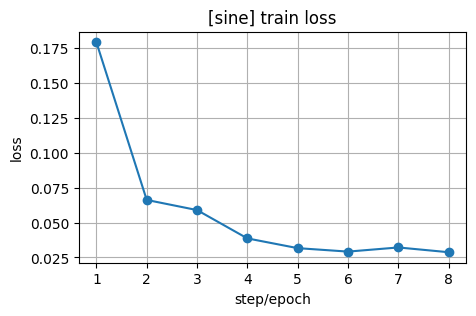

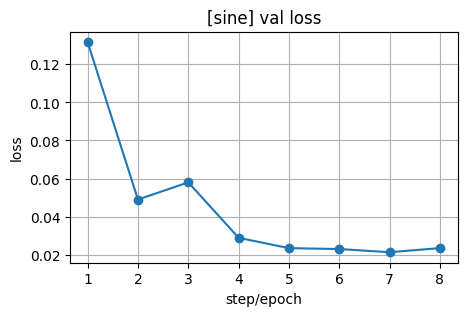

To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take arms against a sea of 
[rope] step 50: train=0.056 val=0.027
[rope] step 100: train=0.034 val=0.025
[rope] step 150: train=0.028 val=0.024
[rope] step 200: train=0.024 val=0.023
[rope] step 250: train=0.028 val=0.024
[rope] step 300: train=0.027 val=0.021
[rope] step 350: train=0.024 val=0.025
[rope] step 400: train=0.023 val=0.021


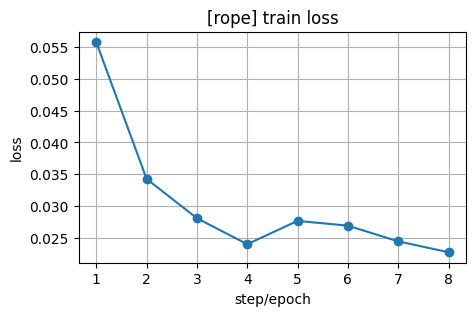

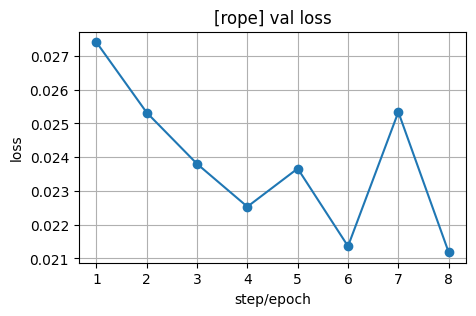

To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take arms against a sea of 


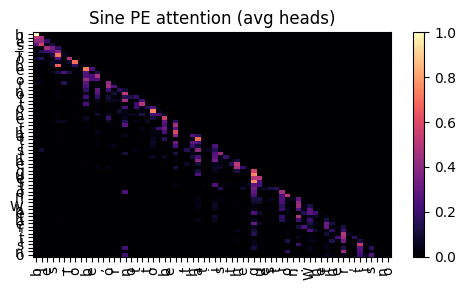

In [15]:
# ===== Запуск =====
model_sine, stoi, itos, tr_s, val_s = train_char_lm("sine", steps=400)
plot_curve(tr_s, "[sine] train loss"); plot_curve(val_s, "[sine] val loss")
print(sample(model_sine, stoi, itos, "To ", 160, temperature=1.0)[:300])

model_rope, _, _, tr_r, val_r = train_char_lm("rope", steps=400)
plot_curve(tr_r, "[rope] train loss"); plot_curve(val_r, "[rope] val loss")
print(sample(model_rope, stoi, itos, "To ", 160, temperature=1.0)[:300])

# Визуализация attention на коротком батче
x,_ = get_char_batches(tiny_char_data()[0], ctx=64, bs=1)
x = x.to(DEVICE)
with torch.no_grad():
    _, attns = model_sine(x)
att = attns[-1][0].mean(0).cpu().numpy()  # последний блок, среднее по головам
tok_seq = [list(stoi.keys())[list(stoi.values()).index(int(i))] for i in x[0].cpu().tolist()]
show_attention_heatmap(att, x_ticks=tok_seq, y_ticks=tok_seq, title="Sine PE attention (avg heads)")


In [16]:
# ===== Sanity-тесты (SDPA & RoPE) =====
def _no_nan(x):
    if torch.is_tensor(x): return torch.isfinite(x).all().item()
    return np.isfinite(x).all()

def check_sdpa(ScaledDotProductAttention):
    print("[SDPA] sanity")
    B,h,T,d = 2,3,6,8
    Q = torch.randn(B,h,T,d); K = torch.randn(B,h,T,d); V = torch.randn(B,h,T,d)
    mask = causal_mask(T, Q.device)
    sdpa = ScaledDotProductAttention(0.0)
    out, P = sdpa(Q,K,V,attn_mask=mask)
    assert out.shape == (B,h,T,d) and P.shape==(B,h,T,T)
    assert _no_nan(out) and _no_nan(P)
    s = P.sum(-1)
    allowed_rows = mask.squeeze(0).squeeze(0).any(-1)
    for bi in range(B):
        for hi in range(h):
            vals = s[bi,hi,allowed_rows]
            assert torch.allclose(vals, torch.ones_like(vals), atol=1e-4)
    iu = torch.triu_indices(T,T,1)
    assert (P[0,0].detach().numpy()[iu[0], iu[1]] < 1e-5).all()
    print("  PASS")

def check_rope(rope_rotate):
    print("[RoPE] sanity")
    B,h,T,d = 1,2,5,8
    x = torch.randn(B,h,T,d)
    cos, sin = rope_cache(T, d, x.device)
    xr = rope_rotate(x, cos, sin)
    assert xr.shape == x.shape and _no_nan(xr)
    n1 = torch.linalg.vector_norm(x, dim=-1)
    n2 = torch.linalg.vector_norm(xr, dim=-1)
    assert torch.allclose(n1, n2, atol=1e-5)
    q, k = torch.randn(B,h,T,d), torch.randn(B,h,T,d)
    qr, kr = rope_rotate(q, cos, sin), rope_rotate(k, cos, sin)
    d1 = (q*k).sum(-1); d2 = (qr*kr).sum(-1)
    assert torch.allclose(d1, d2, atol=1e-5)
    print("  PASS")

check_sdpa(ScaledDotProductAttention)
check_rope(rope_rotate)


[SDPA] sanity
  PASS
[RoPE] sanity
  PASS


Что написать в кратком резюме: какие лоссы/перплексии у sine и rope; визуально — чем отличаются генерации на длинных отрезках; замеченные эффекты.

## Задача 3. Seq2Seq RNN + собственный attention (Bahdanau/Luong)

Научить Seq2Seq-модель с вниманием приводить даты из разных «живых» записей к единому каноническому виду ISO (YYYY-MM-DD).

**Примеры входов:**
"28 Jan 1999", "Jan 28, 1999", "1999/01/28", "28/01/1999", "01-28-1999 <US>", "19990128", "1st of February, 2004", " 07.03.1998 ".

**Данные:** Генерируются в коде: форматы (текстовые и числовые), лишние пробелы/знаки, ординальные суффиксы (1st, 2nd…), локаль-подсказка для неоднозначных чисто числовых дат: <US> (MM-DD-YYYY) и <EU> (DD-MM-YYYY). Таргет всегда YYYY-MM-DD.

**Что сделать:**
обучить модель на синтетике разнородных форматов;
показать Exact-Match по валидации;
визуализировать 2–3 attention-карты;

**Критерии:**
EM (вал) ≥ 0.94 (i.i.d. микс);
EM по «чисто числовым» с подсказкой <US>/<EU> ≥ 0.90;

**Бонусы:** (можно выбрать любой по желанию, можно все сделать)
- Добавить новый сценарий для дат в генерации и дообучить на более шумных данных;
- Luong (dot) вместо Bahdanau и сравнить эмпирически - вывод описать;
- попробовать beam-search vs greedy (b=5) - вывод описать



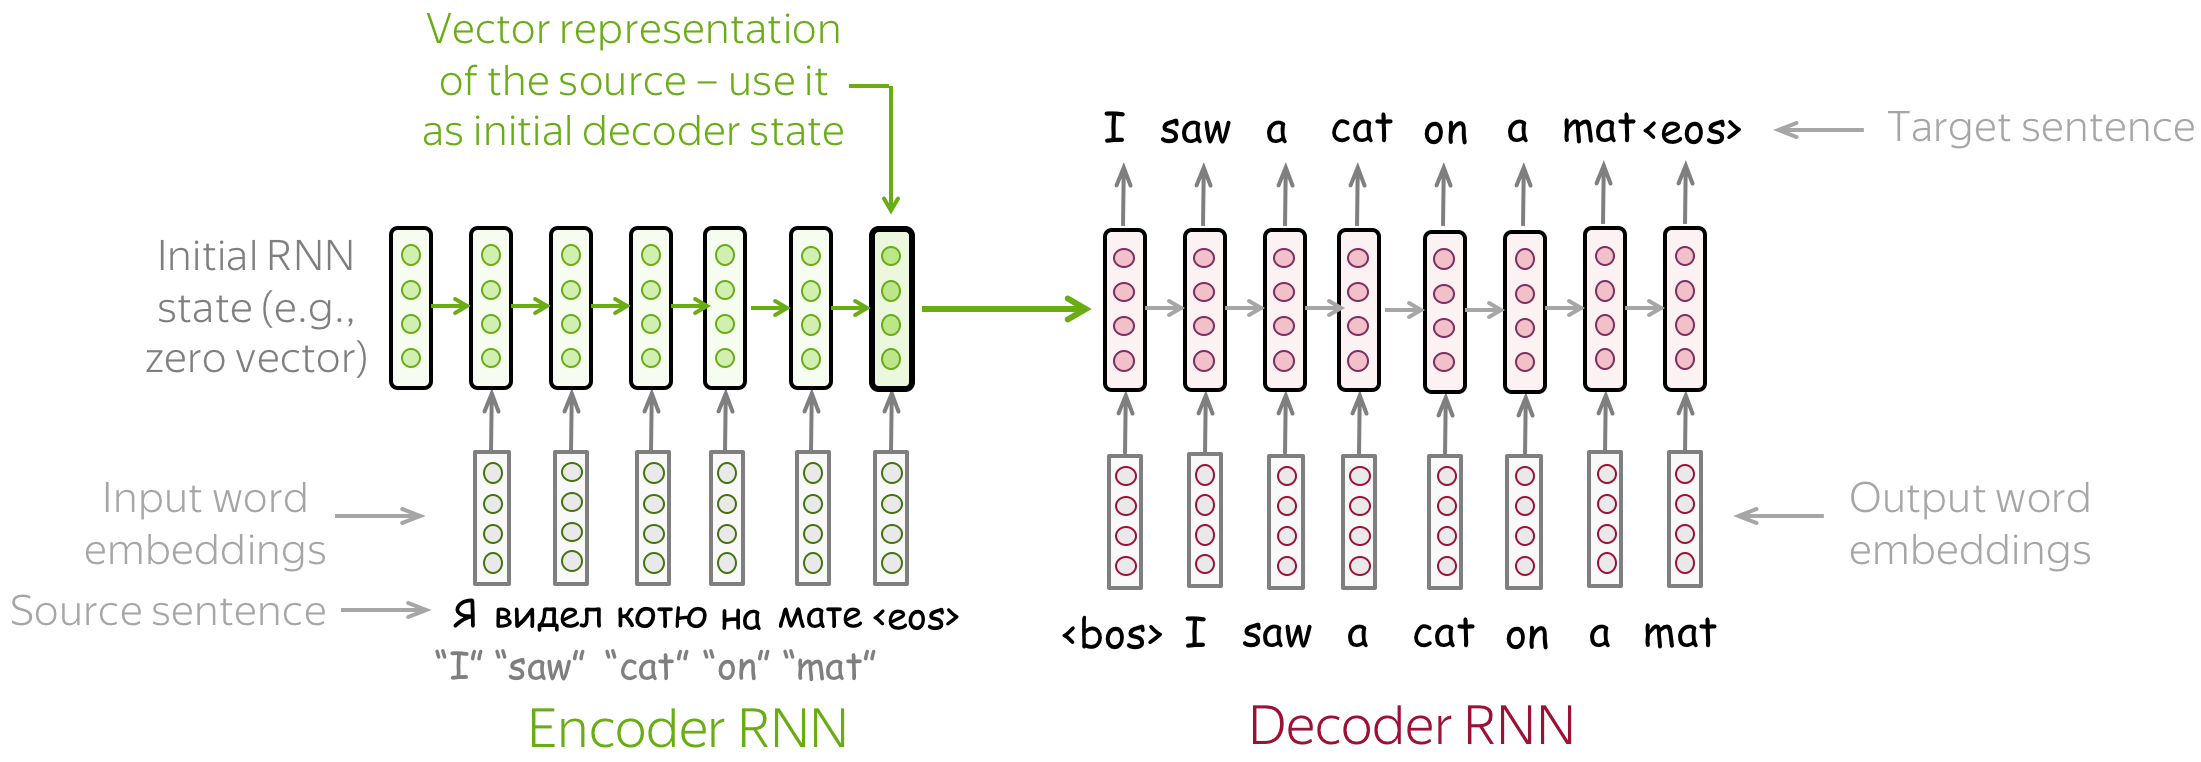

In [17]:
# ====== Генератор дат ======
import random, re, math
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

MONTHS_EN_S = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
MONTHS_EN_L = ["January","February","March","April","May","June","July","August","September","October","November","December"]
ORD = {1:"st",2:"nd",3:"rd"}
def ord_suffix(d):
    return ORD.get(d if d not in (11,12,13) else 0, "th")  # 11/12/13 → th

def noise_spaces(s):
    # случайные лишние пробелы/запятые
    s = re.sub(r"\s+", " ", s.strip())
    if random.random() < 0.3: s = " " * random.randint(1,2) + s
    if random.random() < 0.3: s = s + " " * random.randint(1,2)
    if random.random() < 0.2: s = s.replace(" ", "  ")
    return s

def render_any_date():
    """Вернёт (src, tgt, meta) где tgt=YYYY-MM-DD, meta: dict(fmt, locale, kind)"""
    y = random.randint(1970, 2030)
    m = random.randint(1, 12)
    d = random.randint(1, 28)
    tgt = f"{y:04d}-{m:02d}-{d:02d}"

    fmt = random.choice([
        "iso_dash", "iso_slash", "eu_slash", "eu_dot", "us_dash", "us_slash",
        "compact", "text_short", "text_long", "text_ord"
    ])

    locale = None
    if fmt in {"eu_slash","eu_dot"}:       # DD/MM/YYYY или DD.MM.YYYY
        src = f"{d:02d}/{m:02d}/{y:04d}" if fmt=="eu_slash" else f"{d:02d}.{m:02d}.{y:04d}"
        locale = "EU"
    elif fmt in {"us_dash","us_slash"}:     # MM-DD-YYYY или MM/DD/YYYY
        src = f"{m:02d}-{d:02d}-{y:04d}" if fmt=="us_dash" else f"{m:02d}/{d:02d}/{y:04d}"
        locale = "US"
    elif fmt == "iso_dash":                 # YYYY-MM-DD
        src = f"{y:04d}-{m:02d}-{d:02d}"
        locale = "ISO"
    elif fmt == "iso_slash":                # YYYY/MM/DD
        src = f"{y:04d}/{m:02d}/{d:02d}"
        locale = "ISO"
    elif fmt == "compact":                  # YYYYMMDD
        src = f"{y:04d}{m:02d}{d:02d}"
        locale = "ISO"
    elif fmt == "text_short":               # 28 Jan 1999
        src = f"{d:02d} {MONTHS_EN_S[m-1]} {y:04d}"
        locale = "EN"
    elif fmt == "text_long":                # January 28, 1999
        src = f"{MONTHS_EN_L[m-1]} {d}, {y:04d}"
        locale = "EN"
    elif fmt == "text_ord":                 # 1st of February, 2004
        suf = ord_suffix(d)
        src = f"{d}{suf} of {MONTHS_EN_L[m-1]}, {y:04d}"
        locale = "EN"
    else:
        raise ValueError(fmt)

    # добавим подсказку для чисто числовых неоднозначных
    kind = "numeric" if fmt in {"eu_slash","eu_dot","us_dash","us_slash","iso_dash","iso_slash","compact"} else "text"
    if kind == "numeric" and locale in {"US","EU"} and random.random() < 0.8:
        src = src + " " + f"<{locale}>"

    src = noise_spaces(src)
    return src, tgt, {"fmt": fmt, "locale": locale, "kind": kind}

def make_pairs_any(n=120_000):
    return [render_any_date() for _ in range(n)]


In [18]:
# ====== Построение датасета (символы + спец токены) ======
PAD, SOS, EOS = 0, 1, 2

pairs_any = make_pairs_any(120_000)

src_texts = [s for s,_,_ in pairs_any]
tgt_texts = [t for _,t,_ in pairs_any]
meta_list = [m for _,_,m in pairs_any]

# алфавит из данных + спец-символы
alphabet = sorted(set("".join(src_texts + tgt_texts)))
chars = ["<pad>","<s>","</s>"] + alphabet
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for c,i in stoi.items()}

def encode_str(s): return [stoi[c] for c in s]
def decode_ids(ids): return "".join(itos[int(i)] for i in ids if int(i) not in (PAD,SOS,EOS))

SRC_MAXLEN = max(len(s) for s in src_texts)            # переменная длина из-за разных форматов/шумов
TGT_LEN    = 10                                        # "YYYY-MM-DD"
TGT_MAXLEN_IN, TGT_MAXLEN_OUT = TGT_LEN+1, TGT_LEN+1   # <s>+tgt  | tgt+</s>

def encode_batch_var(texts, max_len):
    X = torch.full((len(texts), max_len), PAD, dtype=torch.long)
    L = torch.zeros(len(texts), dtype=torch.long)
    for i,s in enumerate(texts):
        ids = encode_str(s)[:max_len]
        X[i,:len(ids)] = torch.tensor(ids, dtype=torch.long)
        L[i] = len(ids)
    return X, L

def make_dataset_any(pairs, metas):
    src = [s for s,_,_ in pairs]
    tgt = [t for _,t,_ in pairs]
    Xsrc, Lsrc = encode_batch_var(src, SRC_MAXLEN)
    Yin  = torch.full((len(tgt), TGT_MAXLEN_IN), PAD, dtype=torch.long)
    Yout = torch.full((len(tgt), TGT_MAXLEN_OUT), PAD, dtype=torch.long)
    for i, t in enumerate(tgt):
        ids = encode_str(t)
        Yin[i,  :1+len(ids)] = torch.tensor([SOS] + ids, dtype=torch.long)
        Yout[i, :1+len(ids)] = torch.tensor(ids + [EOS], dtype=torch.long)
    return Xsrc, Lsrc, Yin, Yout, metas

# сплиты
N = len(pairs_any)
idx = np.random.permutation(N)
tr, va, te = idx[:int(.8*N)], idx[int(.8*N):int(.9*N)], idx[int(.9*N):]
train_pairs = [pairs_any[i] for i in tr];   train_meta = [meta_list[i] for i in tr]
val_pairs   = [pairs_any[i] for i in va];   val_meta   = [meta_list[i] for i in va]
test_pairs  = [pairs_any[i] for i in te];   test_meta  = [meta_list[i] for i in te]

Xsrc_tr, Lsrc_tr, Yin_tr, Yout_tr, meta_tr = make_dataset_any(train_pairs, train_meta)
Xsrc_va, Lsrc_va, Yin_va, Yout_va, meta_va = make_dataset_any(val_pairs,   val_meta)
Xsrc_te, Lsrc_te, Yin_te, Yout_te, meta_te = make_dataset_any(test_pairs,  test_meta)

train_ds = TensorDataset(Xsrc_tr, Lsrc_tr, Yin_tr, Yout_tr)
val_ds   = TensorDataset(Xsrc_va, Lsrc_va, Yin_va, Yout_va)
test_ds  = TensorDataset(Xsrc_te, Lsrc_te, Yin_te, Yout_te)

print("Vocab:", len(chars), "| SRC_MAXLEN:", SRC_MAXLEN)
assert stoi["<pad>"]==PAD and stoi["<s>"]==SOS and stoi["</s>"]==EOS
assert (Yout_tr!=PAD).any(), "targets became all PAD"


Vocab: 50 | SRC_MAXLEN: 34


In [44]:
class BahdanauAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim=128):
        super().__init__()
        # YOUR CODE HERE: We(enc) + Wd(dec) -> tanh -> v -> score
        self.W_enc = nn.Linear(enc_dim, attn_dim, bias=False)
        self.W_dec = nn.Linear(dec_dim, attn_dim, bias=False)
        self.v = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, enc_out, dec_h, mask=None):
        """
        enc_out: [B, S, enc_dim]  (S = длина source)
        dec_h:   [B, dec_dim]     (текущее скрытое состояние декодера)
        mask:    [B, S]           (True = валиден, False = pad)
        return: (context, weights)
          context: [B, enc_dim]
          weights: [B, S]  (softmax по S)
        """
        # YOUR CODE HERE: посчитать e_ij, применить маску, softmax -> a_ij, контекст как сумма a_ij * enc_out_j
        enc_proj = self.W_enc(enc_out)
        dec_proj = self.W_dec(dec_h).unsqueeze(1)
        e = self.v(torch.tanh(enc_proj + dec_proj)).squeeze(-1)

        if mask is not None:
            e = e.masked_fill(~mask, -1e9)

        weights = F.softmax(e, dim=1)
        context = torch.bmm(weights.unsqueeze(1), enc_out).squeeze(1)

        return context, weights

class Encoder(nn.Module):
    def __init__(self, V, emb=64, hid=128):
        """
        bidirectional GRU/LSTM. Выход хотим [B,S,hid] (одинаков с dec_dim для удобства).
        """
        super().__init__()
        # YOUR CODE HERE: embedding + biGRU/LSTM (+ проекция 2*hid_dir -> hid)
        self.embedding = nn.Embedding(V, emb, padding_idx=PAD)
        self.gru = nn.GRU(emb, hid, bidirectional=True, batch_first=True)
        self.proj = nn.Linear(2 * hid, hid)

    def forward(self, x, lengths):
        """
        x: [B,S] (source ids), lengths: [B]
        return: enc_out [B,S,hid], enc_mask [B,S], h0_for_dec [B,hid]
        """
        # YOUR CODE HERE: pack_padded_sequence, bi-RNN, unpack, проекция, маска, h_for_dec
        x_emb = self.embedding(x)

        packed = nn.utils.rnn.pack_padded_sequence(x_emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.gru(packed)
        enc_out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True, total_length=x.size(1))
        enc_out = self.proj(enc_out)
        enc_mask = torch.arange(x.size(1), device=x.device).unsqueeze(0) < lengths.unsqueeze(1)
        h_combined = torch.cat([hidden[-2], hidden[-1]], dim=1)
        h0 = self.proj(h_combined)

        return enc_out, enc_mask, h0

class Decoder(nn.Module):
    def __init__(self, V, emb=64, hid=128, attn_dim=128):
        super().__init__()
        # YOUR CODE HERE: embedding, GRU/LSTM (input emb+context), out layer, attention
        self.embedding = nn.Embedding(V, emb, padding_idx=PAD)
        self.attention = BahdanauAttention(hid, hid, attn_dim)
        self.gru = nn.GRU(emb + hid, hid, batch_first=True)
        self.out = nn.Linear(hid, V)

    def forward(self, y_inp, enc_out, enc_mask, h0, teacher_forcing=0.5, collect_attn=False):
        """
        y_inp:  [B, T]  (вход декодера: <s> + tgt)
        enc_out:[B, S, hid]
        enc_mask:[B, S] (True=valid)
        h0:     [B, hid] (инициализация декодера)
        return: (logits, attn_seq)
          logits: [B, T, V]
          attn_seq (optional): список из T элементов, каждый [B,S]
        """
        # YOUR CODE HERE: пошаговая генерация, attention на каждом шаге, teacher forcing
        B, T = y_inp.shape
        logits = []
        attn_seq = [] if collect_attn else None

        h = h0.unsqueeze(0)
        y_emb = self.embedding(y_inp)

        for t in range(T):
            context, attn_weights = self.attention(enc_out, h.squeeze(0), enc_mask)
            gru_input = torch.cat([y_emb[:, t], context], dim=1).unsqueeze(1)
            output, h = self.gru(gru_input, h)

            logit = self.out(output.squeeze(1))
            logits.append(logit)

            if collect_attn:
                attn_seq.append(attn_weights)

            if t < T - 1 and random.random() > teacher_forcing and self.training:
                with torch.no_grad():
                    next_token = logit.argmax(-1)

                y_emb[:, t+1] = self.embedding(next_token)

        logits = torch.stack(logits, dim=1)

        return logits, attn_seq

    def decode_step(self, y_last, enc_out, enc_mask, h):
        """
        Один шаг декодера для инференса
        y_last: [B] (последний предсказанный токен)
        enc_out: [B, S, hid]
        enc_mask: [B, S]
        h: [B, hid] (скрытое состояние)
        return: (logits, new_h, attn_weights)
        """
        y_emb = self.embedding(y_last).unsqueeze(1)
        context, attn_weights = self.attention(enc_out, h, enc_mask)
        gru_input = torch.cat([y_emb.squeeze(1), context], dim=1).unsqueeze(1)

        output, new_h = self.gru(gru_input, h.unsqueeze(0))
        logits = self.out(output.squeeze(1))

        return logits, new_h.squeeze(0), attn_weights

class Seq2Seq(nn.Module):
    def __init__(self, V, emb=64, hid=128, attn_dim=128, cell="gru"):
        super().__init__()
        self.encoder = Encoder(V, emb=emb, hid=hid)
        self.decoder = Decoder(V, emb=emb, hid=hid, attn_dim=attn_dim)
    def encode(self, Xsrc, Lsrc):
        return self.encoder(Xsrc, Lsrc)  # enc_out, enc_mask, h0
    def decode_step(self, y_last, enc_out, enc_mask, h):
        return self.decoder.decode_step(y_last, enc_out, enc_mask, h)
    def forward(self, Xsrc, Lsrc, Yin, teacher_forcing=0.5, collect_attn=False):
        enc_out, enc_mask, h0 = self.encoder(Xsrc, Lsrc)
        return self.decoder(Yin, enc_out, enc_mask, h0, teacher_forcing, collect_attn)


In [45]:
# ===== Train / Eval / Viz =====
def _unpack_batch(batch):
    """Поддерживает и (Xsrc,Lsrc,Yin,Yout) и (Xsrc,Lsrc,Yin,Yout,Ltg)."""
    if len(batch) == 5:
        Xsrc, Lsrc, Yin, Yout, _ = batch
    elif len(batch) == 4:
        Xsrc, Lsrc, Yin, Yout = batch
    else:
        raise ValueError(f"Unexpected batch size: {len(batch)}")
    return Xsrc, Lsrc, Yin, Yout

def train_epoch(model, loader, opt, clip=1.0, tf_ratio=0.5):
    import torch.nn.functional as F
    model.train()
    losses = []
    for batch in loader:
        Xsrc, Lsrc, Yin, Yout = _unpack_batch(batch)
        Xsrc, Lsrc = Xsrc.to(DEVICE), Lsrc.to(DEVICE)
        Yin,  Yout = Yin.to(DEVICE),  Yout.to(DEVICE)
        opt.zero_grad()
        logits, _ = model(Xsrc, Lsrc, Yin, teacher_forcing=tf_ratio, collect_attn=False)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Yout.view(-1), ignore_index=PAD)
        loss.backward()
        if clip: nn.utils.clip_grad_norm_(model.parameters(), clip)
        opt.step()
        losses.append(float(loss.item()))
    return float(np.mean(losses))

def exact_match_accuracy(model, loader):
    model.eval()
    em_ok, total = 0, 0
    with torch.no_grad():
        for batch in loader:
            Xsrc, Lsrc, Yin, Yout = _unpack_batch(batch)
            Xsrc, Lsrc = Xsrc.to(DEVICE), Lsrc.to(DEVICE)
            Yin,  Yout = Yin.to(DEVICE),  Yout.to(DEVICE)
            enc_out, enc_mask, h0 = model.encode(Xsrc, Lsrc)
            B = Xsrc.size(0)
            y = torch.full((B, 1), SOS, dtype=torch.long, device=DEVICE)
            outs = []
            for _ in range(TGT_MAXLEN_OUT):
                logits, h0, _ = model.decode_step(y[:, -1], enc_out, enc_mask, h0)
                nxt = logits.argmax(-1)
                outs.append(nxt.unsqueeze(1))
                y = torch.cat([y, nxt.unsqueeze(1)], dim=1)
            pred = torch.cat(outs, dim=1)                      # [B, T]
            match = (pred == Yout[:, :pred.size(1)]).all(dim=1)
            em_ok += int(match.sum().item()); total += B
    return em_ok / max(1, total)

def plot_curve(values, title, ylabel="loss"):
    xs = np.arange(1, len(values)+1)
    plt.plot(xs, values, marker="o"); plt.grid(True)
    plt.title(title); plt.xlabel("epoch"); plt.ylabel(ylabel); plt.show()


In [46]:
# ====== Обучение ======

# Попробуйте подобрать оптимальные параметры обучения
BATCH= 128 # YOUR CODE HERE
EPOCHS= 15 # YOUR CODE HERE
LR= 0.001 # YOUR CODE HERE

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

model = Seq2Seq(V=len(chars), emb=64, hid=128, attn_dim=128).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR)

best_em, best_state = 0.0, None
train_losses, val_em = [], []
for ep in range(1, EPOCHS+1):
    tf_ratio = 0.6 + (0.2-0.6)*(ep-1)/(EPOCHS-1)  # линейный schedule TF 0.6→0.2
    tr = train_epoch(model, train_loader, opt, clip=1.0, tf_ratio=tf_ratio)
    em = exact_match_accuracy(model, val_loader)
    train_losses.append(tr); val_em.append(em)
    print(f"epoch {ep:02d} | tf={tf_ratio:.2f} | train {tr:.3f} | val EM {em:.4f}")
    if em>best_em:
        best_em=em; best_state={k:v.cpu() for k,v in model.state_dict().items()}
if best_state: model.load_state_dict({k:v.to(DEVICE) for k,v in best_state.items()})
print("Test EM:", exact_match_accuracy(model, test_loader))


epoch 01 | tf=0.60 | train 0.625 | val EM 0.8423
epoch 02 | tf=0.57 | train 0.020 | val EM 0.9885
epoch 03 | tf=0.54 | train 0.008 | val EM 0.9807
epoch 04 | tf=0.51 | train 0.006 | val EM 0.9896
epoch 05 | tf=0.49 | train 0.006 | val EM 0.9901
epoch 06 | tf=0.46 | train 0.004 | val EM 0.9906
epoch 07 | tf=0.43 | train 0.004 | val EM 0.9898
epoch 08 | tf=0.40 | train 0.005 | val EM 0.9884
epoch 09 | tf=0.37 | train 0.004 | val EM 0.9886
epoch 10 | tf=0.34 | train 0.004 | val EM 0.9908
epoch 11 | tf=0.31 | train 0.004 | val EM 0.9900
epoch 12 | tf=0.29 | train 0.004 | val EM 0.9899
epoch 13 | tf=0.26 | train 0.003 | val EM 0.9903
epoch 14 | tf=0.23 | train 0.003 | val EM 0.9869
epoch 15 | tf=0.20 | train 0.005 | val EM 0.9895
Test EM: 0.9904166666666666


In [47]:
# ====== Пер-форматные метрики ======
def em_per_group(model, pairs, metas, batch=256, group_key="fmt"):
    model.eval()
    # батчим ручками для соответствия metas
    ok = []
    for i in range(0, len(pairs), batch):
        chunk = pairs[i:i+batch]
        Xsrc, Lsrc, Yin, Yout, _ = make_dataset_any(chunk, metas[i:i+batch])
        Xsrc, Lsrc, Yin, Yout = Xsrc.to(DEVICE), Lsrc.to(DEVICE), Yin.to(DEVICE), Yout.to(DEVICE)
        with torch.no_grad():
            enc_out, enc_mask, h0 = model.encode(Xsrc, Lsrc)
            B = Xsrc.size(0)
            y = torch.full((B,1), SOS, dtype=torch.long, device=DEVICE)
            outs=[]
            for t in range(TGT_MAXLEN_OUT):
                logits, h0, _ = model.decode_step(y[:,-1], enc_out, enc_mask, h0)
                nxt = logits.argmax(-1)
                outs.append(nxt.unsqueeze(1))
                y = torch.cat([y, nxt.unsqueeze(1)], dim=1)
            pred = torch.cat(outs, dim=1)
            match = (pred == Yout[:,:pred.size(1)]).all(dim=1).cpu().numpy()
            ok.extend(list(match))
    # агрегируем по ключу
    from collections import defaultdict
    groups = defaultdict(lambda: [0,0])
    for good, m in zip(ok, metas):
        key = m[group_key]
        groups[key][0]+=int(good); groups[key][1]+=1
    return {k: v[0]/max(1,v[1]) for k,v in groups.items()}

print("EM per fmt (val):", em_per_group(model, val_pairs, val_meta, group_key="fmt"))
print("EM per locale (val):", em_per_group(model, val_pairs, val_meta, group_key="locale"))


EM per fmt (val): {'us_slash': 0.9602704987320372, 'text_short': 1.0, 'compact': 0.9991197183098591, 'eu_slash': 0.9500805152979066, 'iso_dash': 1.0, 'eu_dot': 1.0, 'text_ord': 1.0, 'iso_slash': 1.0, 'us_dash': 1.0, 'text_long': 1.0}
EM per locale (val): {'US': 0.9797238999137188, 'EN': 1.0, 'ISO': 0.9997175939000282, 'EU': 0.9746938775510204}


In [48]:
# ====== Инференс ======
@torch.no_grad()
def normalize_date(raw, return_attn=False):
    ids = torch.tensor([[stoi[c] for c in raw]], dtype=torch.long, device=DEVICE)
    L = torch.tensor([len(raw)], dtype=torch.long, device=DEVICE)
    enc_out, enc_mask, h = model.encode(ids, L)
    y = torch.full((1,1), SOS, dtype=torch.long, device=DEVICE)
    outs, att = [], []
    for _ in range(TGT_MAXLEN_OUT):
        logits, h, a = model.decode_step(y[:,-1], enc_out, enc_mask, h)
        nxt = logits.argmax(-1)
        outs.append(int(nxt.item()))
        if return_attn: att.append(a.squeeze(0).cpu())
        if outs[-1]==EOS: break
        y = torch.cat([y, nxt.unsqueeze(1)], dim=1)
    text = decode_ids(outs)
    attn = torch.stack(att, dim=0).numpy() if (return_attn and att) else None
    return text, attn

# тесты
tests = ["28 Jan 1999", "January 28, 1999", "01/28/1999 <US>", "28/01/1999 <EU>", "19990128", "07.03.1998"]
for t in tests:
    pred, _ = normalize_date(t, return_attn=False)
    print(f"{t}  ->  {pred}")


28 Jan 1999  ->  1999-01-28
January 28, 1999  ->  1999-01-28
01/28/1999 <US>  ->  1999-01-28
28/01/1999 <EU>  ->  1999-01-28
19990128  ->  1999-01-28
07.03.1998  ->  1998-03-07
